<a href="https://colab.research.google.com/github/tomdv18/clasificadorPrendas/blob/main/Clasificador_de_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este clasificador de imagenes utiliza una red neuronal para distinguir imagenes de prendas en blanco y negro y clasificar la prenda segun su tipo (Remera, pantalon, sandalia, zapato, etc)

Utiliza el dataset "fashion_mnist" de la web de Tensorflow

[Link al Dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist?hl=en)


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math


In [ ]:
#Descargar set de datos
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Me genera curiosidad saber que info contiene los metadatos, vemos que, entre otras cosas nos dice que el tamaño del set de entrenamiento ds de 60000 imagenes, mientras que el de pruebas es de 10000

In [ ]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

Veo las distintas clases que existen

In [ ]:
entrenamiento, pruebas = datos['train'], datos['test']
nombres_clases = metadatos.features['label'].names
nombres_clases


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
entrenamiento

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)

def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255
  return imagenes, etiquetas


entrenamiento = entrenamiento.map(normalizar)
pruebas = pruebas.map(normalizar)


datos_entrenamiento = entrenamiento.cache()
datos_pruebas = pruebas.cache()

Dibujo algunas de las imagenes del dataset, con su respectiva categoria

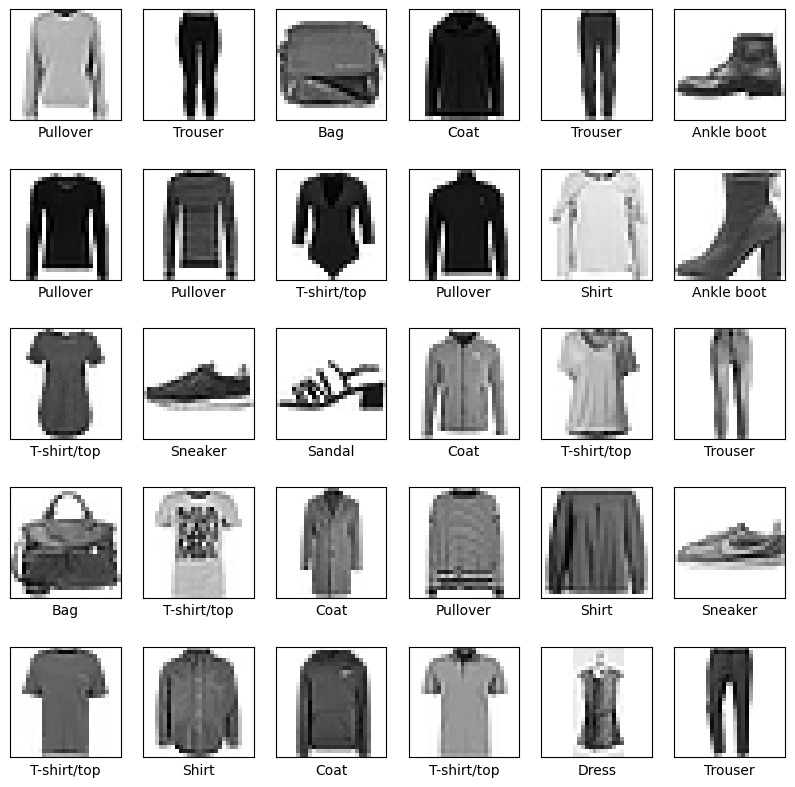

In [ ]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(30)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

Creamos el modelo


In [ ]:
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


Separo en lotes para mejorar la eficiencia

Comienzo a entrenar el modelo

In [ ]:
TAMANO_LOTE = 64

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
entrenamiento = entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
pruebas = pruebas.batch(TAMANO_LOTE)

In [ ]:
#Entrenar
historial = modelo.fit(entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
938/938 [==============================] - 14s 5ms/step - loss: 0.5547 - accuracy: 0.8079
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.4030 - accuracy: 0.8558
Epoch 3/5
938/938 [==============================] - 6s 7ms/step - loss: 0.3656 - accuracy: 0.8681
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.3457 - accuracy: 0.8746
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.3276 - accuracy: 0.8799


Veo que la accuracy ronda el 80%, como es un valor que me parece razonable, prosigo, sino deberia buscar la forma de tunearlo con keras tuner o algo similar

Grafico la funcion de perdida


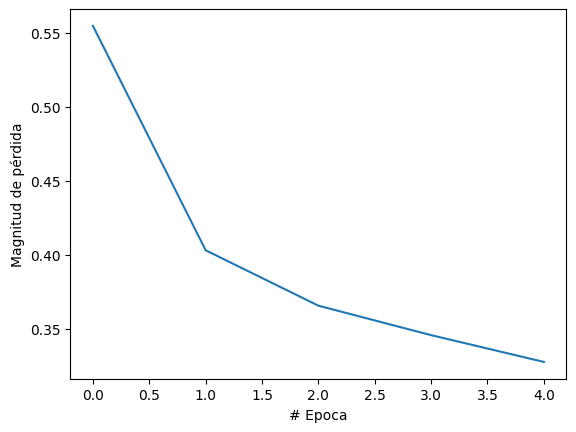

In [ ]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

2/2 [==============================] - 0s 6ms/step


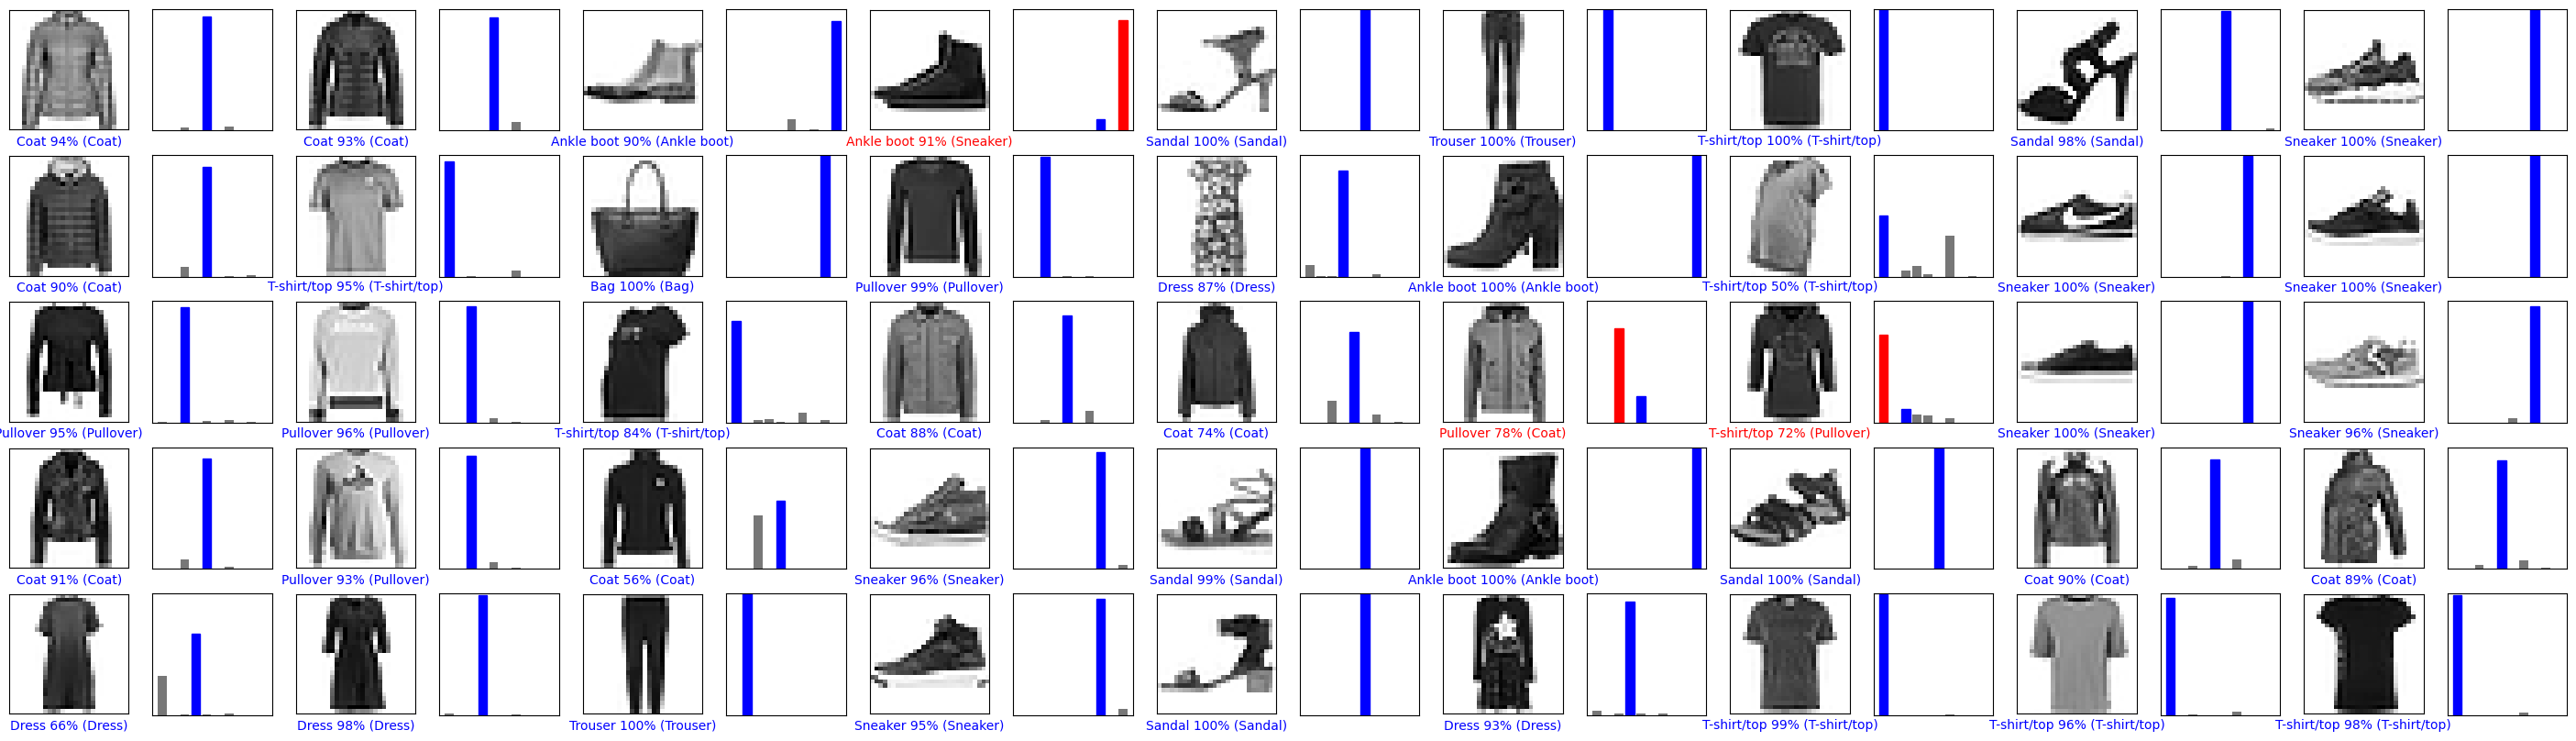

In [ ]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 9
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

1/1 [==============================] - 0s 104ms/step
Prediccion: T-shirt/top
Clase real: T-shirt/top


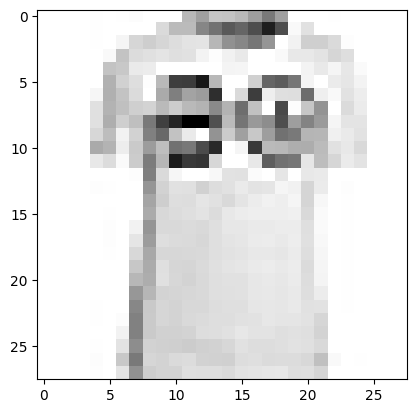

In [ ]:
#Probar una imagen suelta

valor = 51 #Cambiar este valor para elegir una imagen
imagen = imagenes_prueba[valor]
plt.imshow(imagen[...,0], cmap=plt.cm.binary)
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])
print("Clase real: " + nombres_clases[etiquetas_prueba[valor]])